# Radiative transfer model of Titan in Near-IR
- - - - - 

<mate@berkeley.edu>

## Introduction

This is a package for setting up the atmospheric structure of Titan and calculating near-infrared spectra. The atmospheric structure and properties of the aerosol scattering are determined using the measurements made in situ by instruments on the Huygens probe. The gas opacities are calculated from line lists in the HITRAN2012 database. Solutions to the radiative transfer can be performed with the twostream (fast) or discrete ordinates (less fast) methods. Examples of setting up the atmosphere and generating spectra are illustrated below. 

## Reference Data

Due to the size of the reference data sets, they are not stored with the code repository and can be downloaded from a [public HTML directory](http://astro.berkeley.edu/~madamkov/refdata/). 

The method is included to setup the local directory structure and download the reference files specified at the top of the refdata module. Run the following after installation.

    atmosphere.refdata.setup_directory()

## Installation

### 1. The `atmosphere` package can be installed using the standard source distribution installation 

    python setup.py install
    
After installation, which hopefully will compile [CDISORT](http://www.libradtran.org/bin/cdisort-2.1.3.tar.gz) (written by Tim Dowling, as part of [libradtran](http://www.libradtran.org/)), the Python wrappers to this C code are generated with [SWIG](http://www.swig.org/), which can be installed either via the website or via [Homebrew](http://brew.sh/)


### 2. Set the environment variable RTDATAPATH

This can be done from the notebook using 

    import os
    os.environ['RTDATAPATH'] = '/path/to/your/reference/data/'


### 3. Import the atmosphere module and get reference data, e.g., with the code below

In [1]:
import os
os.environ['RTDATAPATH'] = '/Users/mate/g/rt/data/refdata_demo/'

import atmosphere as atm
atm.refdata.setup_directory()

Creating directory: /Users/mate/g/rt/data/refdata_demo/atmosphere_structure/titan
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/atmosphere_structure/titan/HASI_L4_ATMO_PROFILE_DESCEN.TAB
          done.
Creating directory: /Users/mate/g/rt/data/refdata_demo/aerosol/titan
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/aerosol/titan/Tomasko2007_phase_0-80km.TAB
          done.
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/aerosol/titan/Tomasko2007_phase_80-200km.TAB
          done.
Creating directory: /Users/mate/g/rt/data/refdata_demo/gas_opacity/CIA
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/gas_opacity/CIA/N2_N2.fits
          done.
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/gas_opacity/CIA/H2_N2.fits
          done.
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/gas_opacity/kc_CH4.SINFONI.v08.dnu_3.0.fits
          done.
Downloading...: http://astro.berkeley.edu/~madamkov/refdata/gas_opacity/kc_CH

## Example 1. Set up a model atmosphere structure

There is currently a bug in that the kernel needs to be restarted
after downloading the reference data, otherwise the HASI data structure is
undefined.

Something in the methods for getting the reference data are overwriting or clearing teh atm.HASI information

In [2]:
import os
model = atm.structure.set_HASI_structure(nlev=21, method='split_at_tropopause')

atm.composition.set_abundances(model, trace_gas={'m_H2':0.001})

atm.gas_opacity.set_methane(
            model, kc_file=os.path.join(os.getenv('RTDATAPATH'),
                                        'gas_opacity/kc_CH4.SINFONI.v08.dnu_3.0.fits'))
atm.gas_opacity.set_cia(model)
atm.aerosol.set_opacity(model)

DISR = atm.aerosol.fit_DISR_phases()
atm.aerosol.set_aerosol_phase_moments(model, DISR, nmom=24)

view = {'umu0':0.90630776,
        'phi0':200.,
        'umue':0.96592581,
        'phie':195,}

model.update({'view':view})

### There are three ways to divide the atmosphere and set layer boundaries, illustrated below



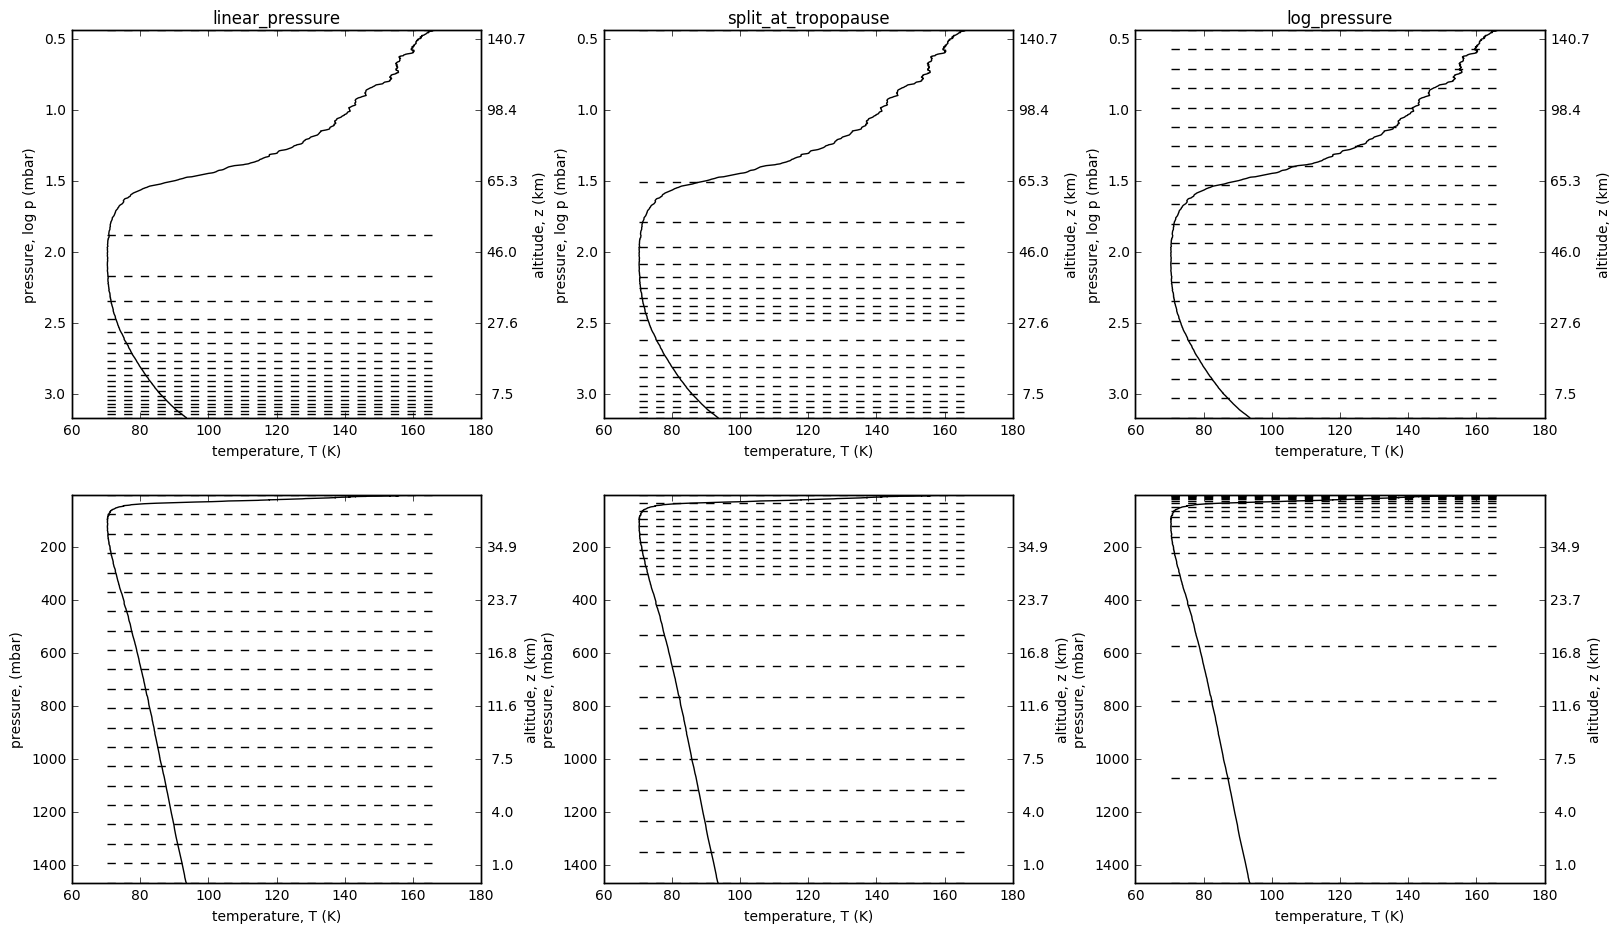

In [3]:
%matplotlib inline
atm.structure.show_atmosphere_structures(model)

## Example 2: Parallel two-stream calculation using atmosphere model

A two-stream solver (`twostream.py`) is included as a module for calculation of spectra, which is implemented using the parallel engines (or clusters). There is also an implementation of CDISORT (a.k.a., PyDISORT) which will require some cc compilation and linking. Documentation for the code is handled within the notebooks and doc strings.

<span style="color:blue"> Start engines under the IPython Clusters tab in Jupyter notebook.  </span>

Running a two-stream calucation without parallelization is built into the module:

    from atmosphere.rt import twostream
    twostream.calc_spectrum(model, hg=0.50, mu0=pseudo_pp(0.7, model, 2575.), rsurf=0.53)

In [4]:
from ipyparallel import Client
engines = Client()
dv = engines[:]
dv.scatter('id', dv.targets, flatten=True)
stride = len(dv)
dv['stride'] = stride

In [5]:
def twostream_parallel(model, hg, mu0, rsurf):
    """Run two-stream calculation in parallel for
    atmosphere model and apend spectrum to data
    structure. Assumes that multiple engines are
    running in IPython notebook."""

    def calc_sub_spectrum(model, hg, mu0, rsurf):
        """Run two-stream calculation on a subset of the
        total spectral bandpass."""

        from numpy import size, zeros, empty, sum
        from atmosphere.rt import twostream    

        tau, ssa = twostream.get_opacity_ssa(model, verbose=False)
        intensities = zeros([model['nlam'], model['layers']['kc']['ng']])
        g_weight = model['layers']['kc']['w']

        chunk = model['nlam']/stride
        imn = int(id*chunk)
        imx = int((id+1)*chunk)
        
        if size(mu0) == 1:
            MU0 = empty(model['nlay']) 
            MU0.fill(mu0)
        else:
            MU0 = mu0

        for iwn in range(imn,imx):
            for g in range(model['layers']['kc']['ng']):
                tau_mono = tau[:,iwn,g]
                ssa_mono = ssa[:,iwn,g]
                g_Imu = twostream.mono(tau_mono, ssa_mono, hg, rsurf, MU0)
                intensities[iwn,g] = g_Imu[0]

        sub_spectrum = sum(intensities*g_weight, axis=1)  

        return sub_spectrum

    from numpy import zeros
    
    spectrum = zeros(model['nlam'])
    spectra = dv.apply_async(calc_sub_spectrum, model, hg, mu0, rsurf)

    for sub_spectrum in spectra.get():
        spectrum += sub_spectrum

    model.update({'spectrum':spectrum,
                'calc':{'method':'twostream_parallel',
                        'hg':hg,
                        'mu0':mu0,
                        'rsurf':rsurf,
                        }
                })
import time
ts = time.time()

from atmosphere.rt.twostream import pseudo_pp
twostream_parallel(model, hg=0.50, mu0=pseudo_pp(0.7, model, 2575.),  rsurf=0.53)
t_run = time.time() - ts
print('Two-stream parallel ({:d} processes) for {:d} channels: {:6.1f} sec.'.format(len(dv), model['nlam'], t_run))

Two-stream parallel (12 processes) for 1992 channels:    1.1 sec.


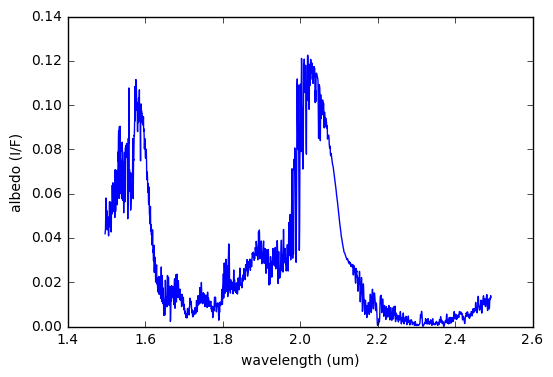

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(model['wavelength'], model['spectrum'])
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('albedo (I/F)') ;

## PyDISORT in parallel

The scattering phase moments need to be calculated and interpolated onto the wavelength grid of the model so 
that CDISORT can be called and used to solve the radiative transfer.


In [14]:
model.update({'radius':2575.,
              'rsurf':0.10,
              'rt':{'spher':False,
                    'wav_range':(2.0,2.40),
                    'view':{'umu0':0.99,'umue': 0.90,'phi0': 10.0,'phie': 11.0},
                   }})
model['haze'].update({'ssalb':0.96})

fi = lambda array, v: abs(array-v).argmin()
wav_indices = lambda array, wavs: tuple([fi(array, mu) for mu in wavs])
wav_mn, wav_mx = wav_indices(model['wavelength'], model['rt']['wav_range'])
model['rt'].update({'wav_mn':wav_mn,
                    'wav_mx':wav_mx,
                    'nlam':wav_mx-wav_mn+1,
                    })    

In [15]:
from atmosphere.rt import pydisort

In [16]:
pydisort.cluster_spectrum_calculation(model)

In [17]:
model['rt']

{'info': 'PyDISORT parallel RT (12 processes) for 801 channels: 36.5 sec',
 'method': 'PyDISORT parallel',
 'nlam': 801,
 'parallel': 'implemented',
 'spher': False,
 't_calc': 36.515501976013184,
 'view': {'phi0': 10.0, 'phie': 11.0, 'umu0': 0.99, 'umue': 0.9},
 'wav_mn': 1006,
 'wav_mx': 1806,
 'wav_range': (2.0, 2.4)}

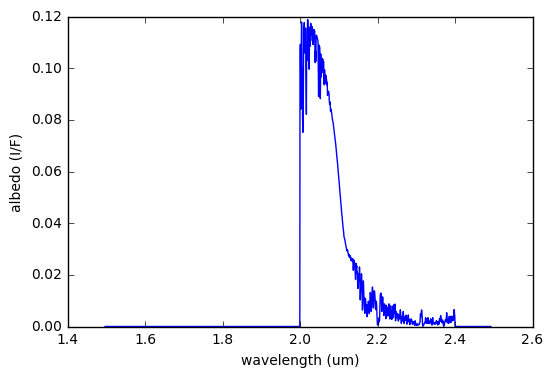

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(model['wavelength'], model['spectrum'])
ax.set_xlabel('wavelength (um)')
ax.set_ylabel('albedo (I/F)') ;